In [1]:
from time import time

In [2]:
tic = time()

In [4]:
from ship_routing.core import Route, WayPoint
from ship_routing.data import load_currents

<frozen abc>:106: FutureWarning: xarray subclass HashableDataset should explicitly define __slots__


In [5]:
import numpy as np
import tqdm
import pandas as pd
import shapely
import warnings
from random import choice
from functools import reduce
from copy import deepcopy, copy

In [8]:
from matplotlib import pyplot as plt
import cartopy

In [9]:
# parameters
resolution = 1_000_000
perturbation_step = 500_000
duration = 14 * 24 * 3600
random_seed = 1234
population_size = 100
keep_best_percent = 20
num_generations = 4
num_refinements = 2

In [10]:
np.random.seed(random_seed)

In [22]:
from ship_routing.data import HashableDataset

In [23]:
currents = load_currents(
    "data/currents/cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_2021-01_100W-020E_10N-65N.nc"
)
currents = currents.where(
    (currents.lon > currents.lon.min())
    & (currents.lon < currents.lon.max())
    & (currents.lat > currents.lat.min())
    & (currents.lat < currents.lat.max())
)
currents["speed"] = (currents.to_array() ** 2).sum("variable") ** 0.5
currents = currents.where(currents.speed > 0)
currents = HashableDataset(currents.compute())

In [24]:
route_ref = Route(
    way_points=(
        WayPoint(lon=-76.5, lat=34, time=np.datetime64("2021-01-01")),
        WayPoint(
            lon=-10,
            lat=40,
            time=np.datetime64("2021-01-01") + np.timedelta64(duration, "s"),
        ),
    )
).refine(distance_meters=resolution)
route_ref

Route(way_points=(WayPoint(lon=np.float64(-76.5), lat=np.int64(34), time=np.datetime64('2021-01-01')), WayPoint(lon=-66.72324582363197, lat=37.61882609793096, time=np.datetime64('2021-01-03T07:59:59.999')), WayPoint(lon=-56.0818173992672, lat=40.351391194218444, time=np.datetime64('2021-01-05T15:59:59.999')), WayPoint(lon=-44.727344997625536, lat=42.03357654925816, time=np.datetime64('2021-01-07T23:59:59.999')), WayPoint(lon=-32.9780534261577, lat=42.54658956790313, time=np.datetime64('2021-01-10T07:59:59.999')), WayPoint(lon=-21.262696209771917, lat=41.85106371408407, time=np.datetime64('2021-01-12T15:59:59.999')), WayPoint(lon=np.float64(-10.0), lat=np.int64(40), time=np.datetime64('2021-01-15T00:00:00'))))

In [25]:
np.mean([l.speed_ms for l in route_ref.legs]) / currents.speed.quantile(0.95).data[
    ()
], np.mean([l.speed_ms for l in route_ref.legs]), currents.speed.quantile(0.95).data[()]

(np.float64(10.036682239627313),
 np.float64(4.81100185935232),
 np.float64(0.47934185266494644))

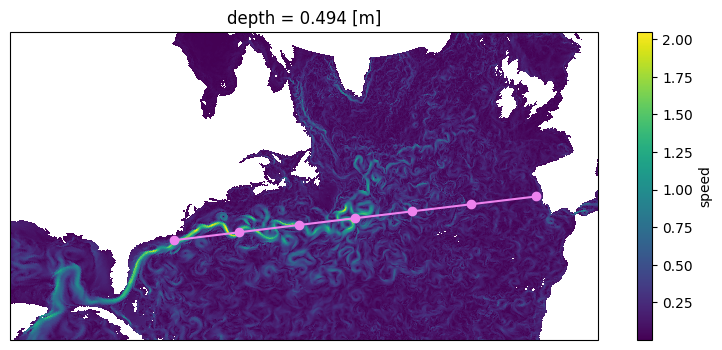

In [26]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(10, 4),
    subplot_kw={
        "projection": cartopy.crs.Gnomonic(
            central_longitude=np.mean(route_ref.line_string.xy[0]),
            central_latitude=np.mean(route_ref.line_string.xy[1]),
        )
    },
)
currents.speed.mean("time").plot(ax=ax, transform=cartopy.crs.PlateCarree())
ax.plot(
    *route_ref.line_string.xy,
    marker="o",
    color="violet",
    transform=cartopy.crs.PlateCarree(),
)
ax.set_extent([-90, -10, 20, 60])

In [27]:
currents

<xarray.HashableDataset> Size: 10MB
Dimensions:  (time: 1, lat: 661, lon: 1321)
Coordinates:
    depth    float32 4B 0.494
  * lat      (lat) float32 3kB 10.0 10.08 10.17 10.25 ... 64.75 64.83 64.92 65.0
  * lon      (lon) float32 5kB -100.0 -99.92 -99.83 -99.75 ... 9.833 9.917 10.0
  * time     (time) datetime64[ns] 8B 2021-01-01
Data variables:
    uo       (time, lat, lon) float32 3MB nan nan nan nan ... nan nan nan nan
    vo       (time, lat, lon) float32 3MB nan nan nan nan ... nan nan nan nan
    speed    (time, lat, lon) float32 3MB nan nan nan nan ... nan nan nan nan

In [28]:
route_ref

Route(way_points=(WayPoint(lon=np.float64(-76.5), lat=np.int64(34), time=np.datetime64('2021-01-01')), WayPoint(lon=-66.72324582363197, lat=37.61882609793096, time=np.datetime64('2021-01-03T07:59:59.999')), WayPoint(lon=-56.0818173992672, lat=40.351391194218444, time=np.datetime64('2021-01-05T15:59:59.999')), WayPoint(lon=-44.727344997625536, lat=42.03357654925816, time=np.datetime64('2021-01-07T23:59:59.999')), WayPoint(lon=-32.9780534261577, lat=42.54658956790313, time=np.datetime64('2021-01-10T07:59:59.999')), WayPoint(lon=-21.262696209771917, lat=41.85106371408407, time=np.datetime64('2021-01-12T15:59:59.999')), WayPoint(lon=np.float64(-10.0), lat=np.int64(40), time=np.datetime64('2021-01-15T00:00:00'))))

In [29]:
population = [deepcopy(route_ref) for n in range(population_size)]
cost = [i.cost_through(currents) for i in population]

In [30]:
def perturb_population(pop, max_step=100_000, num_retry=10):
    pop2 = []
    cost_list = []
    for n in tqdm.tqdm(range(len(population))):
        individual = pop[n]
        cost = individual.cost_through(current_data_set=currents)
        for nret in range(num_retry):
            for npert in range(int(np.random.triangular(1, 1, len(individual) - 1))):
                nwp = np.random.randint(1, len(individual) - 1)
                # modify 80..100 deg portside / starbord
                az = individual.waypoint_azimuth(n=nwp)
                az_mod = az + np.random.uniform(80, 100)  # always to starbord
                _individual = individual.move_waypoint(
                    azimuth_degrees=az_mod,
                    n=nwp,
                    distance_meters=np.random.normal(
                        0, max_step
                    ),  # sign is handled here
                )
            _dist = np.linspace(0, _individual.length_meters, len(_individual))
            _individual = _individual.resample_with_distance(distances_meters=_dist)
            _cost = _individual.cost_through(current_data_set=currents)
            if not np.isnan(_cost):
                individual = _individual
                cost = _cost
                break
        pop2.append(individual)
        cost_list.append(cost)
    return pop2, cost_list

In [31]:
def replicate(population=None, cost=None, keep_best_percent=50, size=None):
    cost_threshold = np.quantile(
        np.array(cost)[~np.isnan(np.array(cost))], keep_best_percent / 100
    )
    pop_filtered = [i for i, c in zip(population, cost) if c < cost_threshold]
    pop_replicated = [choice(pop_filtered) for n in range(size)]
    cost_replicated = [i.cost_through(currents) for i in pop_replicated]
    return pop_replicated, cost_replicated

The following "warms up" the population.

In [32]:
population, cost = perturb_population(population, max_step=perturbation_step)
population, cost = perturb_population(population, max_step=perturbation_step)
population, cost = perturb_population(population, max_step=perturbation_step)
population.append(route_ref)
cost.append(route_ref.cost_through(currents))

100%|████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.12it/s]


In [33]:
population_generations = [
    copy(population),
]

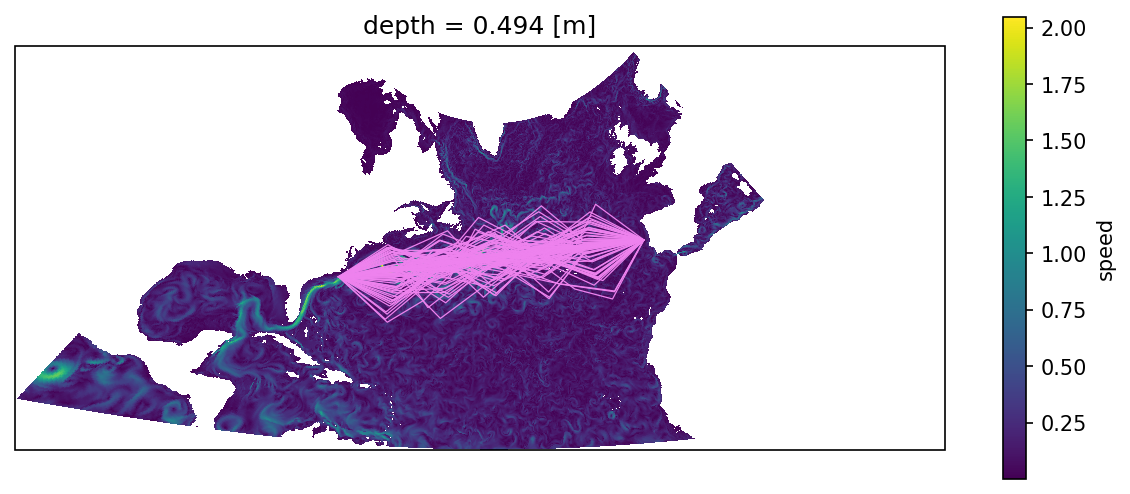

In [34]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(10, 4),
    subplot_kw={
        "projection": cartopy.crs.Gnomonic(
            central_longitude=np.mean(route_ref.line_string.xy[0]),
            central_latitude=np.mean(route_ref.line_string.xy[1]),
        )
    },
)
fig.set_dpi(150)
currents.speed.mean("time").plot(ax=ax, transform=cartopy.crs.PlateCarree())
for indv in population:
    ax.plot(
        *indv.line_string.xy,
        color="violet",
        linewidth=0.6,
        transform=cartopy.crs.PlateCarree(),
    )
# ax.set_extent([-90, -10, None, None])

Then, we run evolution with only the best XX% being retained.

In [ ]:
for nref in range(num_refinements):
    resolution /= 2
    perturbation_step /= 2
    population_size = int(population_size * 1)
    population = [i.refine(distance_meters=resolution) for i in population]
    population = [choice(population) for npop in range(population_size)]

    for ngen in range(num_generations):
        _population, _cost = perturb_population(population, max_step=perturbation_step)
        population, cost = replicate(
            2 * _population + population,
            2 * _cost + cost,
            keep_best_percent=keep_best_percent,
            size=population_size,
        )
        population_generations.append(copy(population))

 16%|███████▊                                         | 16/100 [00:08<00:45,  1.86it/s]

In [ ]:
cost_generations = [
    [r.refine(resolution).cost_through(currents) for r in tqdm.tqdm(_pop)]
    for _pop in population_generations
]

In [ ]:
fig, ax = plt.subplots(
    3,
    3,
    figsize=(8, 6),
    subplot_kw={
        "projection": cartopy.crs.Gnomonic(
            central_longitude=np.mean(route_ref.line_string.xy[0]),
            central_latitude=np.mean(route_ref.line_string.xy[1]),
        )
    },
)
fig.set_dpi(300)
for pop, _ax in zip(population_generations, ax.flatten()):
    currents.speed.plot(ax=_ax, transform=cartopy.crs.PlateCarree(), add_colorbar=False)
    for indv in pop:
        _ax.plot(
            *indv.line_string.xy,
            color="violet",
            linewidth=0.4,
            transform=cartopy.crs.PlateCarree(),
        )
    _ax.set_title("")
    _ax.set_extent([-90, -10, 20, 60])
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(
    3,
    3,
    figsize=(8, 4),
    sharex=True,
    sharey=False,
)
fig.set_dpi(150)
for _cost, _ax in zip(cost_generations, ax.flatten()):
    (
        pd.Series(_cost)
        / route_ref.refine(distance_meters=resolution).cost_through(currents)
    ).plot.hist(bins=np.linspace(0.5, 2, 61), ax=_ax, grid=True)
fig.tight_layout()

In [ ]:
print("took", time() - tic, "seconds")

In [ ]:
(pd.Series(cost) / route_ref.refine(resolution).cost_through(currents)).plot.hist()

In [ ]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(10, 4),
    subplot_kw={
        "projection": cartopy.crs.Gnomonic(
            central_longitude=np.mean(route_ref.line_string.xy[0]),
            central_latitude=np.mean(route_ref.line_string.xy[1]),
        )
    },
)
fig.set_dpi(150)
currents.speed.mean("time").plot(ax=ax, transform=cartopy.crs.PlateCarree())
for indv in population:
    ax.plot(
        *indv.line_string.xy,
        color="violet",
        linewidth=0.4,
        transform=cartopy.crs.PlateCarree(),
    )
ax.set_extent([-90, 10, 25, 60])

In [ ]:
pd.Series([r.length_meters for r in population]).median() / route_ref.length_meters